# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


/dccstor/6195/users/mmacedo/pred_energy_py39_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpu_on = torch.cuda.is_available()

if not gpu_on:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is available!  Training on GPU ...


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
batch_size=32
# Define transforms
transform = transforms.Compose(
    [
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     #transforms.CenterCrop(3),
     #transforms.ColorJitter(contrast=0.5),
     #transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
     #transforms.RandomRotation(degrees=(0, 180)),
     #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
     #transforms.RandomEqualize(),
    ]
     
     )
transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
     
     )


# Create training set and define training dataloader


trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/dccstor/6195/users/mmacedo/pred_energy_py39_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
def show5(img_loader,title):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1]
    images = batch[0].numpy()
    fig = plt.figure(figsize=(25, 4))
    fig.suptitle(title)
    #fig.set_title(title)
    for i in range(5):
    
        image = images[i]
        img = image / 2 + 0.5  # unnormalize
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(img, (1, 2, 0)))  
        #plt.show()
        ax.set_title(classes[labels[i]])
        
def utils_show_images(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

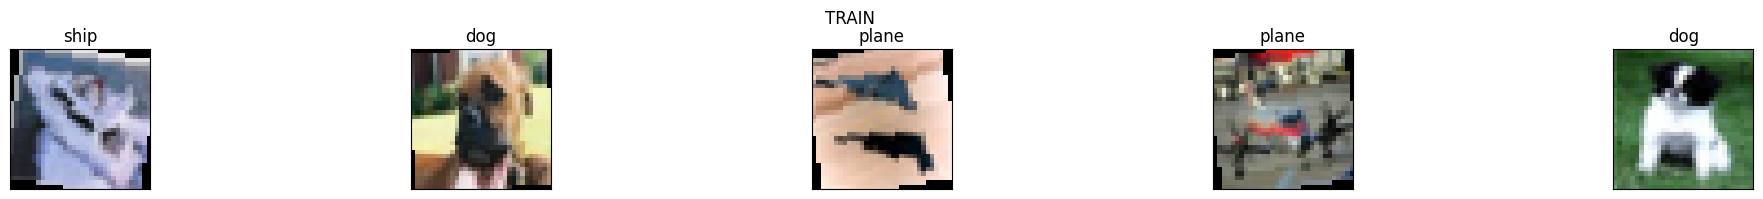

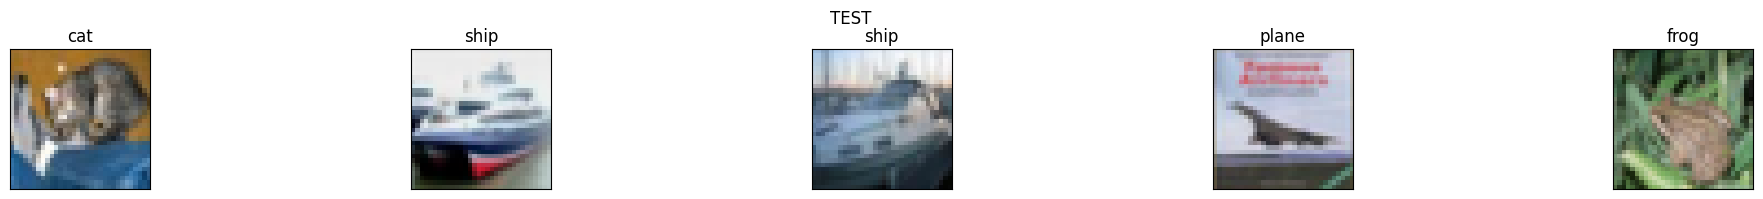

In [6]:
# Explore data
#training data

show5(trainloader, "TRAIN")
show5(testloader, "TEST")

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [59]:
# CNN architecture
class MaysasNet(nn.Module):
    def __init__(self):
        super(MaysasNet, self).__init__()
        # convolutional layer (32x32x3 image tensor)
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        
        self.fc2 = nn.Linear(512, 10)
        # dropout layer (p=0.4)
        self.dropout = nn.Dropout(0.4)
    
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
       
    def forward(self, x):
        # add sequence of convolutional and max pooling layers

        x = self.batchnorm1(self.pool(F.relu(self.conv1(x))))
        x = self.batchnorm2(self.pool(F.relu(self.conv2(x))))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
      
        
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # relu activation function
        x = self.fc2(x)
        return x



# create a complete CNN
model = MaysasNet()
if gpu_on:
    model.cuda()

In [60]:
print(model)

MaysasNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [61]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer

optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [62]:
# number of epochs to train the model
n_epochs = 200

#valid_loss_min = np.Inf # track change in validation loss
train_loss_min = np.Inf # track change in validation loss
train_loss_list =[]
valid_loss_list = []
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if gpu_on:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        
     
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)

    train_loss_list.append(train_loss)
        

    print('Epoch: {} \tTraining Loss: {:.6f} \t'.format(
        epoch, train_loss))
    if train_loss <= train_loss_min:
        train_loss_min=train_loss
        print(' Saving model ...')
        torch.save(model.state_dict(), 'model_cifar10.pt')
    

Epoch: 1 	Training Loss: 1.374452 	
 Saving model ...
Epoch: 2 	Training Loss: 1.111204 	
 Saving model ...
Epoch: 3 	Training Loss: 1.013401 	
 Saving model ...
Epoch: 4 	Training Loss: 0.948879 	
 Saving model ...
Epoch: 5 	Training Loss: 0.902740 	
 Saving model ...
Epoch: 6 	Training Loss: 0.867216 	
 Saving model ...
Epoch: 7 	Training Loss: 0.841052 	
 Saving model ...
Epoch: 8 	Training Loss: 0.805978 	
 Saving model ...
Epoch: 9 	Training Loss: 0.786072 	
 Saving model ...
Epoch: 10 	Training Loss: 0.767405 	
 Saving model ...
Epoch: 11 	Training Loss: 0.746979 	
 Saving model ...
Epoch: 12 	Training Loss: 0.726988 	
 Saving model ...
Epoch: 13 	Training Loss: 0.718582 	
 Saving model ...
Epoch: 14 	Training Loss: 0.711648 	
 Saving model ...
Epoch: 15 	Training Loss: 0.694788 	
 Saving model ...
Epoch: 16 	Training Loss: 0.683474 	
 Saving model ...
Epoch: 17 	Training Loss: 0.683730 	
Epoch: 18 	Training Loss: 0.667386 	
 Saving model ...
Epoch: 19 	Training Loss: 0.666996 	


Epoch: 182 	Training Loss: 0.434851 	
Epoch: 183 	Training Loss: 0.432646 	
 Saving model ...
Epoch: 184 	Training Loss: 0.432056 	
 Saving model ...
Epoch: 185 	Training Loss: 0.438043 	
Epoch: 186 	Training Loss: 0.432141 	
Epoch: 187 	Training Loss: 0.433842 	
Epoch: 188 	Training Loss: 0.428367 	
 Saving model ...
Epoch: 189 	Training Loss: 0.431184 	
Epoch: 190 	Training Loss: 0.431134 	
Epoch: 191 	Training Loss: 0.433312 	
Epoch: 192 	Training Loss: 0.428626 	
Epoch: 193 	Training Loss: 0.428300 	
 Saving model ...
Epoch: 194 	Training Loss: 0.431607 	
Epoch: 195 	Training Loss: 0.436627 	
Epoch: 196 	Training Loss: 0.437500 	
Epoch: 197 	Training Loss: 0.431159 	
Epoch: 198 	Training Loss: 0.426169 	
 Saving model ...
Epoch: 199 	Training Loss: 0.428919 	
Epoch: 200 	Training Loss: 0.429793 	


Plot the training loss (and validation loss/accuracy, if recorded).

In [63]:
#model.load_state_dict(torch.load('model_cifar.pt'))

In [64]:
len(train_loss_list)


200

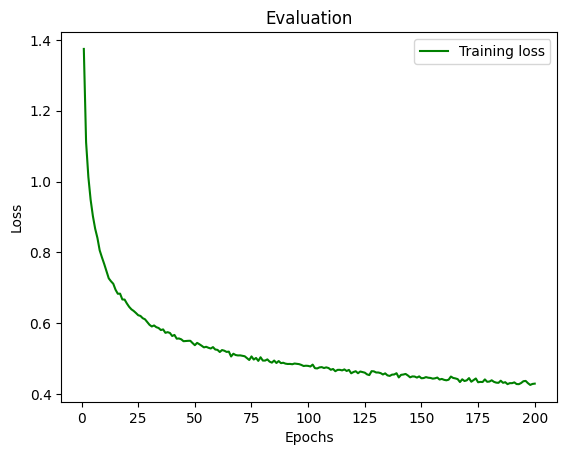

In [65]:
epochs = range(1,n_epochs+1)
plt.plot(epochs, train_loss_list, 'g', label='Training loss')
plt.title('Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [66]:
#testing 

total = 0
correct = 0
model.eval() # out our model in evaluation modewith torch.no_grad():
for data, target in testloader:
    if gpu_on:
        data, target = data.cuda(), target.cuda()
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 84 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [67]:
checkpoint = {'model': model,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

### Recomendations
.. I can recomend my solution for a mobile case, because it need few parameters compared to the first one [78.9% Accuracy | Deep Belief Networks; Krizhevsky, 2010].
However for an accurate app I recommend the follow: [99.0% Accuracy | GPipe; Huang et al., 2018].

.. My solution has a reasonable accuracy, not the best, but it has less number of parameters than the best of literature.
I believe the application of batch normalization help on this result.

.. It is necessary a improvement of the accuracy depending on the infrastructure the user has available, CPU or GPU.

.. A more deep net is needed. More convolutional layers and Hidden layers.





## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).

In [69]:
!jupyter nbconvert --to html /dccstor/6195/users/mmacedo/project4_deeplearning/CIFAR-10_Image_Classifier-STARTER.ipynb

[NbConvertApp] Converting notebook /dccstor/6195/users/mmacedo/project4_deeplearning/CIFAR-10_Image_Classifier-STARTER.ipynb to html
[NbConvertApp] Writing 748886 bytes to /dccstor/6195/users/mmacedo/project4_deeplearning/CIFAR-10_Image_Classifier-STARTER.html
